In [1]:
!pip install tensorflow
!pip install mediapipe
import pandas as pd
import cv2
import numpy as np
import os
import pandas as pd
import cv2
import mediapipe as mp
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import load_model

In [2]:
from google.colab import drive
drive.mount('/content/drive')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:


mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Function to extract pose keypoints from a video
def process_video(video_path, num_frames=32):
    cap = cv2.VideoCapture(video_path)
    keypoints = []
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    step = max(1, frame_count // num_frames)

    for i in range(num_frames):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * step)
        ret, frame = cap.read()
        if not ret:
            break

        # Convert frame to RGB for MediaPipe
        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(image_rgb)

        # Extract pose keypoints if detected
        if results.pose_landmarks:
            frame_keypoints = []
            for landmark in results.pose_landmarks.landmark:
                frame_keypoints.extend([landmark.x, landmark.y, landmark.z, landmark.visibility])
            keypoints.append(frame_keypoints)
        else:
            keypoints.append([0] * (33 * 4))  # Pad with zeros if no keypoints detected

    cap.release()

    # Ensure all videos have the same number of frames
    while len(keypoints) < num_frames:
        keypoints.append([0] * (33 * 4))  # Pad with zeros

    return np.array(keypoints)


def create_dataset_with_progress(video_dir, label, num_frames=32):
    data = []
    video_files = [f for f in os.listdir(video_dir) if f.endswith('.mp4')]  # List of video files
    total_videos = min(len(video_files), max_videos)  # Limit to max_videos

    for idx, video_file in enumerate(video_files[:total_videos], start=1):
        video_path = os.path.join(video_dir, video_file)
        keypoints = process_video(video_path, num_frames)
        data.append({'keypoints': keypoints, 'label': label})

        # Print progress
        print(f"Processed {idx}/{total_videos} videos in directory '{video_dir}'")

    return data

# Paths to healthy and injured videos
healthy_dir = '/content/drive/My Drive/Final_Dataset/Healthy'
injured_dir = '/content/drive/My Drive/Final_Dataset/Injured'

# Create datasets with progress tracking, limited to 750 videos each
print("Processing Healthy videos...")
healthy_data = create_dataset_with_progress(healthy_dir, label=0)

print("\nProcessing Injured videos...")
injured_data = create_dataset_with_progress(injured_dir, label=1)

# Combine and save the dataset
all_data = healthy_data + injured_data
np.save('/content/drive/My Drive/Final_Dataset/pose_dataset.npy', all_data)
print("\nPose dataset saved successfully!")




Processing Healthy videos...


In [2]:
data = np.load('/content/drive/My Drive/Final_Dataset/pose_dataset_5000.npy', allow_pickle=True)

# Prepare features and labels
X = np.array([item['keypoints'] for item in data])  # Shape: (num_samples, num_frames, 33*4)
y = np.array([item['label'] for item in data])      # Shape: (num_samples,)

# Split into training, validation, and test sets
from sklearn.model_selection import train_test_split

# First, split data into train+val and test sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Next, split the remaining train+val set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Reshape input for the model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 33, 4)  # (samples, frames, landmarks, features)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 33, 4)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 33, 4)


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_pose_model(input_shape=(32, 33, 4), num_classes=2):
    model = models.Sequential()

    # Flatten input for fully connected layers
    model.add(layers.Flatten(input_shape=input_shape))

    # Fully Connected Layers
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))  # Dropout to prevent overfitting
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))  # Output layer for classification

    return model

# Build and compile the model
input_shape = (32, 33 * 4)  # 32 frames, flattened (33 keypoints * 4 features)
num_classes = 2
model = build_pose_model(input_shape=input_shape, num_classes=num_classes)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 4224)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       2,163,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,327,682 (8.88 MB)

 Trainable params: 2,327,682 (8.88 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 4224)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       2,163,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,327,682 (8.88 MB)

 Trainable params: 2,327,682 (8.88 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
def build_rnn_model(input_shape=(32, 33, 4), num_classes=2):
    model = models.Sequential()

    # Flatten spatial dimensions (33 keypoints x 4 features per frame)
    model.add(layers.TimeDistributed(layers.Flatten(), input_shape=input_shape))

    # LSTM layers to process temporal data
    model.add(layers.LSTM(128, return_sequences=True))
    model.add(layers.LSTM(64))

    # Fully connected layers
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))  # Output layer

    return model

# Instantiate and compile the model
input_shape = (32, 33, 4)  # 32 frames, 33 keypoints, 4 features (x, y, z, visibility)
num_classes = 2
model = build_rnn_model(input_shape=input_shape, num_classes=num_classes)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 32, 132)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 32, 128)             │         133,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 191,618 (748.51 KB)

 Trainable params: 191,618 (748.51 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
model_path = '/content/drive/My Drive/Final_Dataset/pose_model.h5'
#model_path = '/content/drive/My Drive/Final_Dataset/pose_model_rnn.h5'
model= load_model(model_path)

# Confirm the model is loaded
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_10 (Flatten)                 │ (None, 4224)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 512)                 │       2,163,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,327,684 (8.88 MB)

 Trainable params: 2,327,682 (8.88 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [9]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=250,
    batch_size=16
)

# Save the trained model
model.save('/content/drive/My Drive/Final_Dataset/pose_model.h5')
print("Model saved!")


Epoch 1/250
323/323 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5514 - loss: 0.6969 - val_accuracy: 0.5668 - val_loss: 0.6846
Epoch 2/250
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5837 - loss: 0.6803 - val_accuracy: 0.5668 - val_loss: 0.6847
Epoch 3/250
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5876 - loss: 0.6788 - val_accuracy: 0.5668 - val_loss: 0.6839
Epoch 4/250
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5902 - loss: 0.6769 - val_accuracy: 0.5668 - val_loss: 0.6841
Epoch 5/250
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5836 - loss: 0.6810 - val_accuracy: 0.5668 - val_loss: 0.6836
Epoch 6/250
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5969 - loss: 0.6758 - val_accuracy: 0.5668 - val_loss: 0.6822
Epoch 7/250
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5825 - loss: 0.6766 - val_accuracy: 0.5668 - val_loss: 0.6814
Epoch 8/250
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5869 - loss: 0.6755 - val_accu

Model saved!


In [10]:



# Evaluate the model on the test set
print("Evaluating on test set...")
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predict class probabilities and labels
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute precision, recall, and accuracy
print("\nClassification Metrics:")
print(classification_report(y_test, y_pred))

overall_accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Overall Accuracy: {overall_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Evaluating on test set...
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7292 - loss: 2.0284
Test Loss: 2.0316
Test Accuracy: 0.7253
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Classification Metrics:
              precision    recall  f1-score   support

           0       0.75      0.79      0.77       999
           1       0.68      0.64      0.66       723

    accuracy                           0.73      1722
   macro avg       0.72      0.71      0.72      1722
weighted avg       0.72      0.73      0.72      1722

Overall Accuracy: 0.7253
Precision: 0.7236
Recall: 0.7253


54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5847 - loss: 0.8755
Test Loss: 0.8701961040496826, Test Accuracy: 0.5801393985748291
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


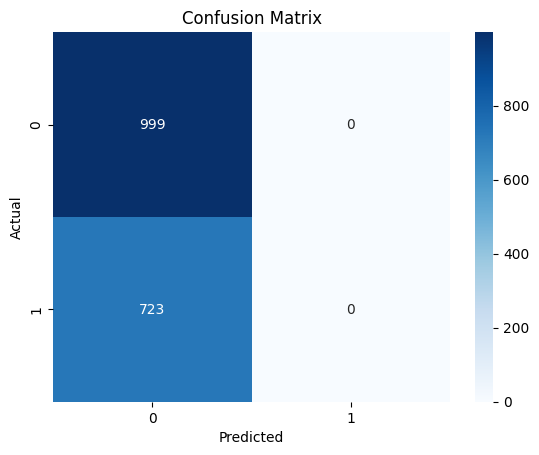

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


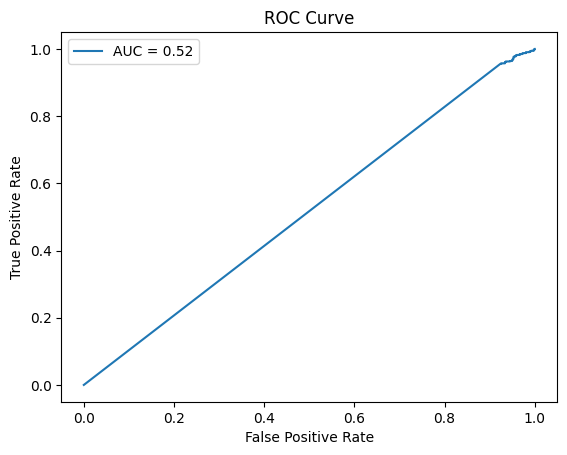

In [7]:
# Assuming X_test and y_test are preprocessed and ready
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Make predictions
y_pred = (model.predict(X_test) > 0.5).astype("int32")
y_pred_binary = np.argmax(y_pred, axis=1)
y_test_binary = y_test.ravel()

# Evaluate performance using metrics like precision, recall, F1-score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Classification metrics
#print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# ROC Curve
y_prob = model.predict(X_test)[:, 1]  # Get probabilities for positive class
auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()